In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
import distances_helper as dh 
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()
printer = PrintHelper()

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_25_01_m3_convex\models.txt


In [3]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold):    
    print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'@default_class': 1.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model
def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold):
    print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='ss_phi_score', class_id='@default_class'))
    artm_model.scores.add(artm.SparsityThetaScore(name='ss_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='@default_class', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='@default_class', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name=''): 
    print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
# def load_pickle_file(filename):
#     pickle_filename = path.join(config.experiment_path, filename)
#     pickle_file = open(pickle_filename, 'rb')
#     p_file = pickle.load(pickle_file)
#     pickle_file.close()
#     return p_file
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
# def load_model_pickle(_model_name, _distance_name):
#     phi = load_pickle_file('phi_{}.p'.format(_model_name))
#     theta = load_pickle_file('theta_{}.p'.format(_model_name))
#     saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name))
#     distances = load_pickle_file('{}.p'.format(_distance_name))
#     return phi, theta, saved_top_tokens, distances
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def load_model_pickle(_model_name, _distance_name=None, _path=config.experiment_path):
    phi = load_pickle_file('phi_{}.p'.format(_model_name), _path)
    theta = load_pickle_file('theta_{}.p'.format(_model_name), _path)
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name), _path)
    distances = None
    if _distance_name is not None:
        distances = load_pickle_file('{}.p'.format(_distance_name), _path)
    return phi, theta, saved_top_tokens, distances

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [5]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_m1')
model1 = tmp_model; tmp_model = None

[2017-01-29 16:49:43.130000] creating model
[2017-01-29 16:49:43.398000] adding scores
[2017-01-29 16:49:43.540000] fitting
[2017-01-29 16:50:05.921000] outputting
name = model_20_m1, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25



In [6]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_m3')
model3 = tmp_model; tmp_model = None

[2017-01-29 16:50:12.600000] creating model
[2017-01-29 16:50:12.802000] adding scores
[2017-01-29 16:50:12.808000] fitting
[2017-01-29 16:51:05.579000] outputting
name = model_100_m3, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25



In [7]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 300
tmp_model.regularizers['ss_theta_regularizer'].tau = -5
tmp_model.regularizers['ss_phi_regularizer'].tau = -20
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_m14')
model14 = tmp_model; tmp_model = None

[2017-01-29 16:51:09.789000] creating model
[2017-01-29 16:51:09.911000] adding scores
[2017-01-29 16:51:09.917000] fitting
[2017-01-29 16:51:28.951000] outputting
name = model_20_m14, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 300
ss_phi_regularizer, tau = -20



In [197]:
def calculate_distances(dist_fun, _phi, _phi_other):
    print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        if idx % 20 == 0:
            print '[{}] column {} / {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def get_optimization_result_one_matrix(dist_fn, jac_dist_fn, phi, distances):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        if col_idx % 20 == 0:
            print '[{}] get_optimization_result for column {} / {}'.format(datetime.now(), col_idx, len(phi.columns))
        column = phi[col_name]
        # delete col from phi
        phi_cut = phi.drop(col_name, axis=1)
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_cut, distances)
    return opt_results
def get_optimization_result(dist_fn, jac_dist_fn, phi, phi_other, distances):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        if col_idx % 20 == 0:
            print '[{}] get_optimization_result for column {} / {}'.format(datetime.now(), col_idx, len(phi.columns))        
        column = phi[col_name]
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_other, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, column, column_name, phi, distances, verbose=False):
    max_iter = 50
    phi_columns = phi.columns
    # cut distances by phi columns 
    cut_distances = distances[phi_columns]
    # get n closest topics
    closest_column_names = cut_distances.loc[column_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_closest = phi[closest_column_names]
    
    # opt solver
    n_columns = phi_closest.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(column, phi_closest.dot(x))
    jac_fun = lambda x: jac_dist_fn(column, phi_closest, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != 4:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    if not is_optimized:
        print 'Not optimized'         
    res['column_names'] = phi_closest.columns
    res['optimized_column'] = column_name
    res['projection'] = phi_closest.dot(res.x)
    res['column'] = column
    return res

In [12]:
phi1, theta1, saved_top_tokens1 = save_model_pickle('model1', model1)
phi3, theta3, saved_top_tokens3 = save_model_pickle('model3', model3)
phi14, theta14, saved_top_tokens14 = save_model_pickle('model14', model14)
distances_hellinger_model1 = calculate_distances(dh.hellinger_dist, phi1, phi1)
distances_hellinger_model3 = calculate_distances(dh.hellinger_dist, phi3, phi3)
distances_hellinger_model14 = calculate_distances(dh.hellinger_dist, phi14, phi14)
save_pickle_file(distances_hellinger_model1, 'distances_hellinger_model1.p')
save_pickle_file(distances_hellinger_model3, 'distances_hellinger_model3.p')
save_pickle_file(distances_hellinger_model14, 'distances_hellinger_model14.p')

[2017-01-25 15:11:58.737000] take_distances between 20 columns and 20 columns
[2017-01-25 15:11:58.737000] column num 0 of 20
[2017-01-25 15:11:58.884000] column num 1 of 20
[2017-01-25 15:11:58.899000] column num 2 of 20
[2017-01-25 15:11:58.922000] column num 3 of 20
[2017-01-25 15:11:58.954000] column num 4 of 20
[2017-01-25 15:11:58.986000] column num 5 of 20
[2017-01-25 15:11:59.004000] column num 6 of 20
[2017-01-25 15:11:59.022000] column num 7 of 20
[2017-01-25 15:11:59.038000] column num 8 of 20
[2017-01-25 15:11:59.053000] column num 9 of 20
[2017-01-25 15:11:59.069000] column num 10 of 20
[2017-01-25 15:11:59.085000] column num 11 of 20
[2017-01-25 15:11:59.100000] column num 12 of 20
[2017-01-25 15:11:59.122000] column num 13 of 20
[2017-01-25 15:11:59.138000] column num 14 of 20
[2017-01-25 15:11:59.154000] column num 15 of 20
[2017-01-25 15:11:59.185000] column num 16 of 20
[2017-01-25 15:11:59.212000] column num 17 of 20
[2017-01-25 15:11:59.230000] column num 18 of 20
[

In [9]:
phi1, theta1, saved_top_tokens1, distances_hellinger_model1 = load_model_pickle('model1', 'distances_hellinger_model1')
phi3, theta3, saved_top_tokens3, distances_hellinger_model3 = load_model_pickle('model3', 'distances_hellinger_model3')
phi14, theta14, saved_top_tokens14, distances_hellinger_model14 = load_model_pickle('model14', 'distances_hellinger_model14')

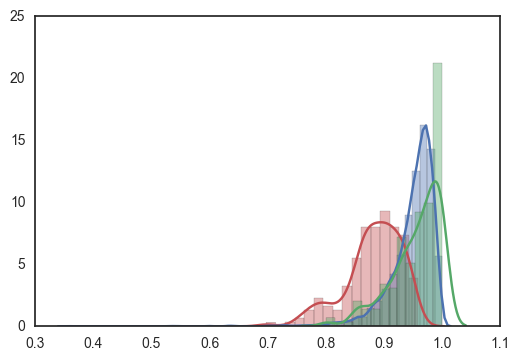

In [19]:
# построим распределение полученных distances
%matplotlib inline
vals = distances_hellinger_model1.values.flatten()
sns.distplot(vals[vals != 0], color='r')
vals = distances_hellinger_model3.values.flatten()
sns.distplot(vals[vals != 0],  color='b')
vals = distances_hellinger_model14.values.flatten()
sns.distplot(vals[vals != 0],  color='g')

In [ ]:
# как и ожидалось, распределения расстояний нерегуляризованных моделей более размазанные 

In [10]:
N_CLOSEST_TOPICS = 50

In [17]:
opt_res_hellinger_model1 = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi1, distances_hellinger_model1)
save_pickle_file(opt_res_hellinger_model1, 'opt_res_hellinger_model1.p')
opt_res_hellinger_model3 = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi3, distances_hellinger_model3)
save_pickle_file(opt_res_hellinger_model3, 'opt_res_hellinger_model3.p')
opt_res_hellinger_model14 = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi14, distances_hellinger_model14)
save_pickle_file(opt_res_hellinger_model14, 'opt_res_hellinger_model14.p')

[2017-01-25 15:14:31.253000] get_optimization_result for column 0
[2017-01-25 15:14:31.750000] get_optimization_result for column 1
[2017-01-25 15:14:32.052000] get_optimization_result for column 2
[2017-01-25 15:14:32.229000] get_optimization_result for column 3
[2017-01-25 15:14:32.714000] get_optimization_result for column 4
[2017-01-25 15:14:33.484000] get_optimization_result for column 5
[2017-01-25 15:14:33.765000] get_optimization_result for column 6
[2017-01-25 15:14:33.985000] get_optimization_result for column 7
[2017-01-25 15:14:34.448000] get_optimization_result for column 8
[2017-01-25 15:14:34.971000] get_optimization_result for column 9
[2017-01-25 15:14:35.472000] get_optimization_result for column 10
[2017-01-25 15:14:35.772000] get_optimization_result for column 11
[2017-01-25 15:14:35.915000] get_optimization_result for column 12
[2017-01-25 15:14:36.555000] get_optimization_result for column 13
[2017-01-25 15:14:36.656000] get_optimization_result for column 14
[2017

In [11]:
opt_res_hellinger_model1 = load_pickle_file('opt_res_hellinger_model1.p')
opt_res_hellinger_model3 = load_pickle_file('opt_res_hellinger_model3.p')
opt_res_hellinger_model14 = load_pickle_file('opt_res_hellinger_model14.p')

In [12]:
# построим распределение полученных opt_fun 
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.distplot([val.fun for val in opt_res_hellinger_model1.itervalues()], color='r', bins=10, ax=ax1, label='model1')
sns.distplot([val.fun for val in opt_res_hellinger_model3.itervalues()], color='b', bins=10, ax=ax1, label='model3')
sns.distplot([val.fun for val in opt_res_hellinger_model14.itervalues()], color='g', bins=10, ax=ax1, label='model14')
ax1.set_title("Inter opts")
ax1.legend()

sns.distplot([val.x[0] for val in opt_res_hellinger_model1.itervalues()], color='r', bins=10, ax=ax2, label='model1')
sns.distplot([val.x[0] for val in opt_res_hellinger_model3.itervalues()], color='b', bins=10, ax=ax2, label='model3')
sns.distplot([val.x[0] for val in opt_res_hellinger_model14.itervalues()], color='g', bins=10, ax=ax2, label='model14')
ax2.set_title("Inter x[0]")
ax2.legend()

In [13]:
def get_topics_to_remove_by_closest_dist(small_dist_opts, distances):
    n_closest = 10
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda opt: opt.x[0])
    topics_to_remove = []
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        is_closest = lambda topic, other_topic: np.any(distances[topic].sort_values().head(n_closest).index.values == other_topic)
        dists_to_topics_to_remove = [not is_closest(topic_name, t) for t in topics_to_remove]
        is_far = np.all(np.array(dists_to_topics_to_remove))
        if is_far:
            topics_to_remove.append(topic_name)
    return topics_to_remove
def find_topics_to_remove(_opt_res, _phi_convex_hull, _distances_convex_hull, x_th):     
    possible_duplicates_opts = {col: _opt_res[col] for col in _phi_convex_hull.columns if _opt_res[col].x[0] > x_th}
    print len(possible_duplicates_opts)
    topics_to_remove_by_closest_dist = get_topics_to_remove_by_closest_dist(possible_duplicates_opts, _distances_convex_hull)
    print 'topics to remove = ', len(topics_to_remove_by_closest_dist)
    print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_closest_dist])
    return topics_to_remove_by_closest_dist

In [23]:
for topic_name in phi1.columns:
    if opt_res_hellinger_model1[topic_name].fun < 0.75:
        printer.print_optimal_solution(opt_res_hellinger_model1[topic_name], _num_components = 10, _distances=distances_hellinger_model1, _saved_top_tokens=saved_top_tokens1)

fun = 0.746343450876, optimized = True
topic_0 | topic_13 : 0.53 [0.79], topic_17 : 0.16 [0.84], topic_5 : 0.15 [0.85], topic_12 : 0.10 [0.83], topic_8 : 0.03 [0.83], topic_19 : 0.01 [0.90], topic_9 : 0.00 [0.89], topic_10 : 0.00 [0.90], topic_11 : 0.00 [0.90], topic_4 : 0.00 [0.87]
closest by distance to topic_0 | topic_0 : [0.00], topic_13 : [0.79], topic_12 : [0.83], topic_8 : [0.83], topic_17 : [0.84], topic_5 : [0.85], topic_3 : [0.85], topic_4 : [0.87], topic_2 : [0.89], topic_9 : [0.89]

fun = 0.70040549109, optimized = True
topic_3 | topic_8 : 0.35 [0.74], topic_6 : 0.22 [0.78], topic_12 : 0.17 [0.79], topic_15 : 0.17 [0.78], topic_13 : 0.08 [0.81], topic_11 : 0.01 [0.88], topic_10 : 0.00 [0.92], topic_7 : 0.00 [0.88], topic_5 : 0.00 [0.87], topic_17 : 0.00 [0.88]
closest by distance to topic_3 | topic_3 : [0.00], topic_8 : [0.74], topic_6 : [0.78], topic_15 : [0.78], topic_12 : [0.79], topic_13 : [0.81], topic_4 : [0.83], topic_1 : [0.85], topic_0 : [0.85], topic_5 : [0.87]

f

In [23]:
for topic_name in phi2.columns:
    if opt_res_hellinger_model2[topic_name].fun < 0.75:
        printer.print_optimal_solution(opt_res_hellinger_model2[topic_name], _num_components = 10, _distances=distances_hellinger_model2, _saved_top_tokens=saved_top_tokens2)

fun = 0.749611922322, optimized = True
topic_34 | topic_46 : 0.17 [0.84], topic_21 : 0.16 [0.85], topic_72 : 0.13 [0.85], topic_48 : 0.12 [0.87], topic_63 : 0.09 [0.87], topic_97 : 0.08 [0.86], topic_88 : 0.04 [0.89], topic_32 : 0.04 [0.87], topic_75 : 0.03 [0.89], topic_62 : 0.03 [0.88]
closest by distance to topic_34 | topic_34 : [0.00], topic_46 : [0.84], topic_72 : [0.85], topic_21 : [0.85], topic_97 : [0.86], topic_33 : [0.86], topic_48 : [0.87], topic_32 : [0.87], topic_63 : [0.87], topic_62 : [0.88]

fun = 0.745764286756, optimized = True
topic_66 | topic_90 : 0.15 [0.86], topic_29 : 0.14 [0.85], topic_81 : 0.10 [0.86], topic_51 : 0.09 [0.86], topic_78 : 0.09 [0.85], topic_27 : 0.08 [0.88], topic_17 : 0.07 [0.87], topic_40 : 0.06 [0.87], topic_8 : 0.06 [0.89], topic_38 : 0.05 [0.86]
closest by distance to topic_66 | topic_66 : [0.00], topic_78 : [0.85], topic_29 : [0.85], topic_90 : [0.86], topic_81 : [0.86], topic_38 : [0.86], topic_51 : [0.86], topic_17 : [0.87], topic_40 : [0

In [32]:
for topic_name in phi3.columns:
    if opt_res_hellinger_model3[topic_name].fun < 1:
        printer.print_optimal_solution(opt_res_hellinger_model3[topic_name], _num_components = 10, _distances=distances_hellinger_model3, _saved_top_tokens=saved_top_tokens3)

fun = 0.83761228933, optimized = True
topic_0 | topic_7 : 0.21 [0.90], topic_63 : 0.18 [0.92], topic_77 : 0.13 [0.91], topic_36 : 0.12 [0.91], topic_35 : 0.09 [0.91], topic_33 : 0.06 [0.92], topic_39 : 0.04 [0.93], topic_91 : 0.04 [0.95], topic_84 : 0.03 [0.93], topic_34 : 0.02 [0.94]
closest by distance to topic_0 | topic_0 : [0.00], topic_7 : [0.90], topic_35 : [0.91], topic_77 : [0.91], topic_36 : [0.91], topic_63 : [0.92], topic_58 : [0.92], topic_85 : [0.92], topic_33 : [0.92], topic_44 : [0.92]

fun = 0.798133530715, optimized = True
topic_1 | topic_75 : 0.22 [0.88], topic_74 : 0.20 [0.89], topic_8 : 0.15 [0.89], topic_87 : 0.11 [0.90], topic_39 : 0.08 [0.92], topic_15 : 0.07 [0.87], topic_97 : 0.04 [0.93], topic_0 : 0.03 [0.93], topic_6 : 0.02 [0.90], topic_62 : 0.02 [0.93]
closest by distance to topic_1 | topic_1 : [0.00], topic_15 : [0.87], topic_75 : [0.88], topic_8 : [0.89], topic_74 : [0.89], topic_87 : [0.90], topic_6 : [0.90], topic_46 : [0.91], topic_91 : [0.92], topic_6

In [25]:
models_file.close()

Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [53]:
phi_original, theta_original, saved_top_tokens_original, distances_hellinger_model_original = load_model_pickle('model3', 'distances_hellinger_model3', config.output_batches_path)
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


In [33]:
distances_hellinger_model_1_to_original = calculate_distances(dh.hellinger_dist, phi1, phi_original)
save_pickle_file(distances_hellinger_model_1_to_original, 'distances_hellinger_model_1_to_original.p')
distances_hellinger_model_3_to_original = calculate_distances(dh.hellinger_dist, phi3, phi_original)
save_pickle_file(distances_hellinger_model_3_to_original, 'distances_hellinger_model_3_to_original.p')
distances_hellinger_model_14_to_original = calculate_distances(dh.hellinger_dist, phi14, phi_original)
save_pickle_file(distances_hellinger_model_14_to_original, 'distances_hellinger_model_14_to_original.p')

[2017-01-25 15:30:36.401000] take_distances between 20 columns and 100 columns
[2017-01-25 15:30:36.402000] column num 0 of 20
[2017-01-25 15:30:36.977000] column num 1 of 20
[2017-01-25 15:30:37.420000] column num 2 of 20
[2017-01-25 15:30:37.877000] column num 3 of 20
[2017-01-25 15:30:38.327000] column num 4 of 20
[2017-01-25 15:30:38.826000] column num 5 of 20
[2017-01-25 15:30:39.280000] column num 6 of 20
[2017-01-25 15:30:39.743000] column num 7 of 20
[2017-01-25 15:30:40.197000] column num 8 of 20
[2017-01-25 15:30:40.667000] column num 9 of 20
[2017-01-25 15:30:41.115000] column num 10 of 20
[2017-01-25 15:30:41.547000] column num 11 of 20
[2017-01-25 15:30:42.014000] column num 12 of 20
[2017-01-25 15:30:42.448000] column num 13 of 20
[2017-01-25 15:30:42.927000] column num 14 of 20
[2017-01-25 15:30:43.402000] column num 15 of 20
[2017-01-25 15:30:43.834000] column num 16 of 20
[2017-01-25 15:30:44.286000] column num 17 of 20
[2017-01-25 15:30:44.824000] column num 18 of 20


In [14]:
distances_hellinger_model_1_to_original = load_pickle_file('distances_hellinger_model_1_to_original.p')
distances_hellinger_model_3_to_original = load_pickle_file('distances_hellinger_model_3_to_original.p')
distances_hellinger_model_14_to_original = load_pickle_file('distances_hellinger_model_14_to_original.p')

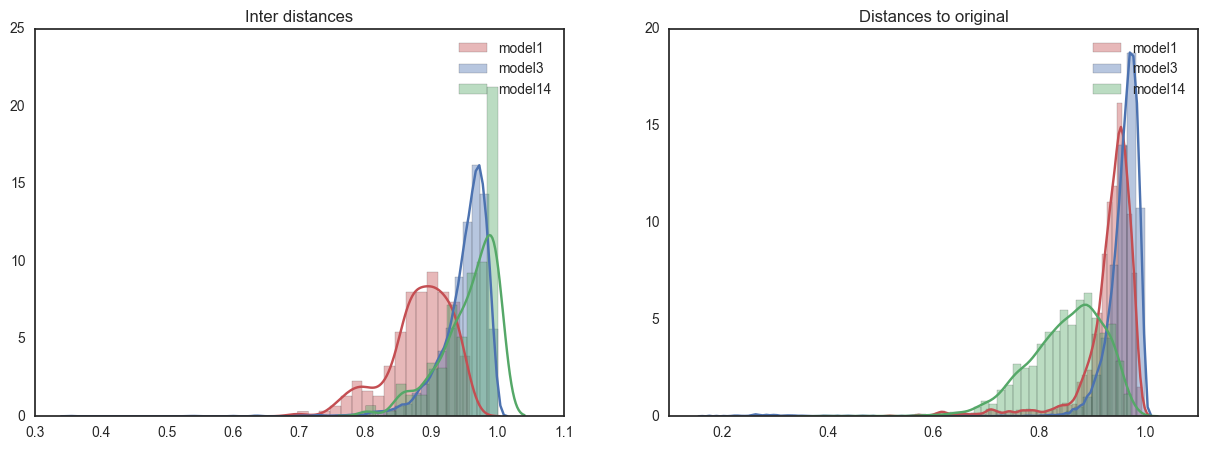

In [18]:
# построим распределение полученных distances
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
vals = distances_hellinger_model1.values.flatten()
sns.distplot(vals[vals != 0], color='r', ax = ax1, label='model1')
vals = distances_hellinger_model3.values.flatten()
sns.distplot(vals[vals != 0],  color='b', ax = ax1, label='model3')
vals = distances_hellinger_model14.values.flatten()
sns.distplot(vals[vals != 0],  color='g', ax = ax1, label='model14')
ax1.set_title("Inter distances")
ax1.legend()

vals = distances_hellinger_model_1_to_original.values.flatten()
sns.distplot(vals[vals != 0],  color='r', ax = ax2, label='model1')
vals = distances_hellinger_model_3_to_original.values.flatten()
sns.distplot(vals[vals != 0],  color='b', ax = ax2, label='model3')
vals = distances_hellinger_model_14_to_original.values.flatten()
sns.distplot(vals[vals != 0],  color='g', ax = ax2, label='model14')
ax2.set_title("Distances to original")
ax2.legend()

In [36]:
opt_res_hellinger_model_1_to_original = get_optimization_result(dh.hellinger_dist, None, phi1, phi_original, distances_hellinger_model_1_to_original)
save_pickle_file(opt_res_hellinger_model_1_to_original, 'opt_res_hellinger_model_1_to_original.p')
opt_res_hellinger_model_3_to_original = get_optimization_result(dh.hellinger_dist, None, phi3, phi_original, distances_hellinger_model_3_to_original)
save_pickle_file(opt_res_hellinger_model_3_to_original, 'opt_res_hellinger_model_3_to_original.p')
opt_res_hellinger_model_14_to_original = get_optimization_result(dh.hellinger_dist, None, phi14, phi_original, distances_hellinger_model_14_to_original)
save_pickle_file(opt_res_hellinger_model_14_to_original, 'opt_res_hellinger_model_14_to_original.p')

[2017-01-25 15:36:02.306000] get_optimization_result for column 0
[2017-01-25 15:36:34.529000] get_optimization_result for column 1
[2017-01-25 15:36:41.274000] get_optimization_result for column 2
[2017-01-25 15:36:48.713000] get_optimization_result for column 3
[2017-01-25 15:37:05.921000] get_optimization_result for column 4
[2017-01-25 15:37:13.321000] get_optimization_result for column 5
[2017-01-25 15:37:22.992000] get_optimization_result for column 6
[2017-01-25 15:37:48.360000] get_optimization_result for column 7
[2017-01-25 15:37:59.958000] get_optimization_result for column 8
[2017-01-25 15:38:05.051000] get_optimization_result for column 9
[2017-01-25 15:38:11.924000] get_optimization_result for column 10
[2017-01-25 15:38:16.365000] get_optimization_result for column 11
[2017-01-25 15:38:23.845000] get_optimization_result for column 12
[2017-01-25 15:38:31.145000] get_optimization_result for column 13
[2017-01-25 15:38:44.270000] get_optimization_result for column 14
[2017

In [16]:
opt_res_hellinger_model_1_to_original = load_pickle_file('opt_res_hellinger_model_1_to_original.p')
opt_res_hellinger_model_3_to_original = load_pickle_file('opt_res_hellinger_model_3_to_original.p')
opt_res_hellinger_model_14_to_original = load_pickle_file('opt_res_hellinger_model_14_to_original.p')

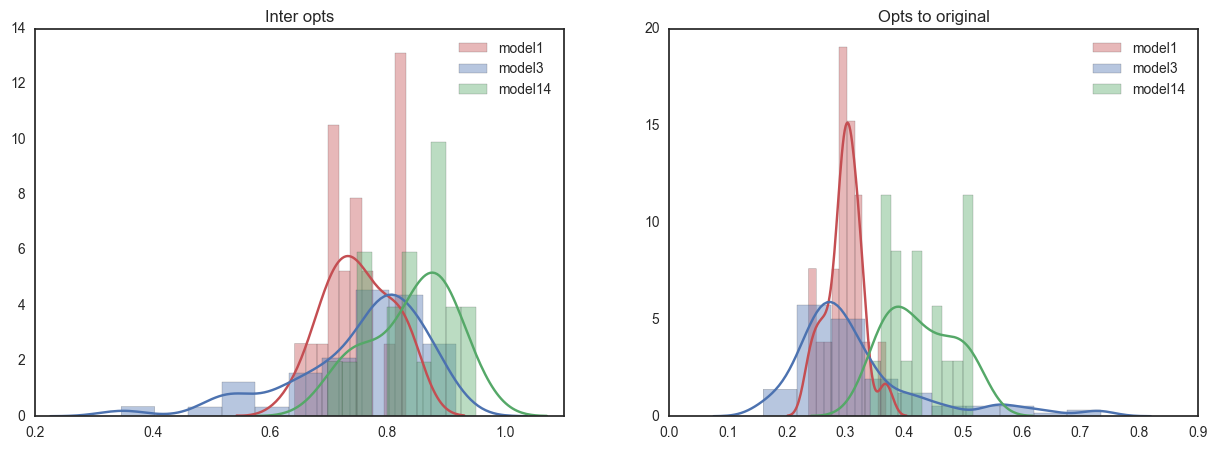

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.distplot([val.fun for val in opt_res_hellinger_model1.itervalues()], color='r', bins=10, ax=ax1, label='model1')
sns.distplot([val.fun for val in opt_res_hellinger_model3.itervalues()], color='b', bins=10, ax=ax1, label='model3')
sns.distplot([val.fun for val in opt_res_hellinger_model14.itervalues()], color='g', bins=10, ax=ax1, label='model14')
ax1.set_title("Inter opts")
ax1.legend()

sns.distplot([val.fun for val in opt_res_hellinger_model_1_to_original.itervalues()], color='r', bins=10, ax=ax2, label='model1')
sns.distplot([val.fun for val in opt_res_hellinger_model_3_to_original.itervalues()], color='b', bins=10, ax=ax2, label='model3')
sns.distplot([val.fun for val in opt_res_hellinger_model_14_to_original.itervalues()], color='g', bins=10, ax=ax2, label='model14')
ax2.set_title("Opts to original")
ax2.legend()

In [36]:
opt_res_hellinger_model_1_to_original['topic_2'].keys()

['status',
 'fun',
 'column_names',
 'projection',
 'success',
 'column',
 'jac',
 'nfev',
 'optimized_column',
 'x',
 'message',
 'njev',
 'nit']

In [87]:
print opt_res_hellinger_model_1_to_original['topic_19']['projection'].sort_values()[::-1][0:10]
print [(t, opt_res_hellinger_model_14_to_original[t]['fun']) for t in opt_res_hellinger_model_14_to_original.keys()]

культура     0.170567
ребёнок      0.151010
искусство    0.063952
семья        0.044996
родитель     0.033602
взрослый     0.027560
жизнь        0.025228
рождение     0.021922
форма        0.019463
фольклор     0.019003
dtype: float64
[(u'topic_19', 0.50954198926166505), (u'topic_18', 0.38811396988422237), (u'topic_13', 0.51788438868698083), (u'topic_12', 0.36589402894365086), (u'topic_11', 0.45278543931465409), (u'topic_10', 0.50644187731543289), (u'topic_17', 0.40970556174832146), (u'topic_16', 0.37177678552767451), (u'topic_15', 0.38444468673755766), (u'topic_14', 0.46557837303772254), (u'topic_7', 0.38606523250937269), (u'topic_6', 0.41416679503281878), (u'topic_5', 0.42958759878532249), (u'topic_4', 0.46211437076987194), (u'topic_3', 0.36034505831639313), (u'topic_2', 0.36520002819630748), (u'topic_1', 0.42087707321038659), (u'topic_0', 0.50631187177677683), (u'topic_9', 0.34241053364409352), (u'topic_8', 0.49552090833226836)]


In [83]:
idx = 1
model_1_topic = 'topic_19'
print opt_res_hellinger_model_14_to_original[model_1_topic]['fun'], opt_res_hellinger_model_14_to_original[model_1_topic]['x'][idx]
original_closest_topic = opt_res_hellinger_model_14_to_original[model_1_topic]['column_names'][idx]
for w in saved_top_tokens_original[original_closest_topic]:
    print w

0.509541989262 0.339563133244
вселенная
материя
наблюдение
геометрия
космология
теория
масштаб
момент
вещество
существование
флуктуация
кривая
реликтовый_излучение
химический_состав
плотность


Запустить несколько раз с разным рандомом. Следить за тем, чтобы накапливались только независимые темы. Каждый раз смотреть. как проектируется на оригинальную матрицу.

In [284]:
N_CLOSEST_TOPICS = 10
OPT_FUN_THRESHOLD = 0.5
def create_model_fn_1(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                             n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_m1_iter_{}'.format(n_iteration))
    return tmp_model
def build_convex_hull(create_model_fn, words, init_convex_hull=None, start_iteration = 0, max_iteration=5):
    # init phi of convex hull
    phi_convex_hull = init_convex_hull
    if len(phi_convex_hull) == 0:
        phi_convex_hull = pd.DataFrame(0, index = words, columns=[])
    iterations_info = []
    for n_iteration in range(start_iteration, start_iteration + max_iteration):
        print('[{}] iteration = {} / {}'.format(datetime.now(), n_iteration, start_iteration + max_iteration))
        # build model
        model = create_model_fn(n_iteration)
        phi = model.get_phi()
        # rename phi columns 
        phi.columns = [c + '_{}'.format(n_iteration) for c in phi.columns]
        # add to convex hull
        phi_convex_hull_expanded = pd.concat([phi_convex_hull, phi], axis=1)
        # get new opts results
        distances_model_iter = calculate_distances(dh.hellinger_dist, phi_convex_hull_expanded, phi_convex_hull_expanded)
        opt_res_convex_hull_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, 
                                                                       phi_convex_hull_expanded, distances_model_iter)
        # get topics to remove
        topics_to_remove, not_removed_topics_count = get_topics_to_remove_by_opt_fun(opt_res_convex_hull_inter, distances_model_iter)
        # update phi convex
#         print phi_convex_hull_expanded.shape, topics_to_remove
        phi_convex_hull = remove_topics_from_phi(phi_convex_hull_expanded, topics_to_remove)
        iterations_info.append({'it': n_iteration,
                                'n_topics_to_remove': len(topics_to_remove),
                                'phi_convex_hull_shape': phi_convex_hull.shape,
                                'removed_topics': topics_to_remove,
                                'not_removed_topics_count': not_removed_topics_count})
        print('[{}] {} topics to remove, {} not_removed_topics_count because close topics, current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['n_topics_to_remove'], not_removed_topics_count, iterations_info[-1]['phi_convex_hull_shape']))
    return phi_convex_hull, iterations_info
def get_topics_to_remove_by_opt_fun_and_distance(opt_res, distances, n_closest=N_CLOSEST_TOPICS):
    small_dist_opts = {k:i for k, i in opt_res.iteritems() if i['fun'] < OPT_FUN_THRESHOLD}
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda opt: opt['fun'])
    topics_to_remove = []
    not_removed_count = 0 
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        is_close_fn = lambda topic, other_topic: other_topic in distances[topic].sort_values().head(n_closest).index
        is_close_to_topics_to_remove = [is_close_fn(topic_name, t) for t in topics_to_remove]
        is_close_to_topics_to_remove = True in is_close_to_topics_to_remove 
        if not is_close_to_topics_to_remove:
            topics_to_remove.append(topic_name)
        else:
            not_removed_count += 1 
    return topics_to_remove, not_removed_count
def get_topics_to_remove_by_opt_fun(opt_res, n_closest=N_CLOSEST_TOPICS):
    small_dist_opts = {k:i for k, i in opt_res.iteritems() if i['fun'] < OPT_FUN_THRESHOLD}
    topics_to_remove = [x['optimized_column'] for x in small_dist_opts]
    not_removed_count = 0
    return topics_to_remove, not_removed_count
def remove_topics_from_phi(phi, topics_to_remove):
    return phi.drop(topics_to_remove, axis=1)
def remove_topics_from_distances_x(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=0)
    return distances_convex_hull
def remove_topics_from_distances_xy(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=1)
    distances_convex_hull = distances_convex_hull.drop(topics_to_remove, axis=0)
    return distances_convex_hull
def filter_convex_hull(phi_convex_hull, max_iteration=5):
    distances_model_iter = calculate_distances(dh.hellinger_dist, phi_convex_hull, phi_convex_hull)
    iterations_info = []
    for n_iteration in range(max_iteration):
        print('[{}] iteration = {} / {}'.format(datetime.now(), n_iteration, max_iteration))
        # get new opts results
        opt_res_convex_hull_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, 
                                                                       phi_convex_hull, distances_model_iter)
        # get topics to remove
        topics_to_remove, not_removed_topics_count = get_topics_to_remove_by_opt_fun(opt_res_convex_hull_inter, distances_model_iter)
        # update phi convex
        phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove)
        distances_model_iter = remove_topics_from_distances_xy(distances_model_iter, topics_to_remove)
        iterations_info.append({'it': n_iteration, 
                                'n_topics_to_remove': len(topics_to_remove),
                                'phi_convex_hull_shape': phi_convex_hull.shape,
                                'removed_topics': topics_to_remove,
                                'not_removed_topics_count': not_removed_topics_count})
        print('[{}] {} topics to remove, {} not_removed_topics_count because close topics, current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['n_topics_to_remove'], not_removed_topics_count, iterations_info[-1]['phi_convex_hull_shape']))
        if len(iterations_info) > 3 and iterations_info[-1]['n_topics_to_remove'] == 0 and iterations_info[-2]['n_topics_to_remove'] == 0:
            print('[{}] topics to remove not increasing, breaking the for loop'.format(datetime.now()))
            break
    return phi_convex_hull, iterations_info

In [214]:
phi_convex_hull, iterations_info = build_convex_hull(create_model_fn_1, phi_original.index, max_iteration=50)

[2017-01-29 19:14:33.225000] iteration = 0 / 50
[2017-01-29 19:14:33.225000] creating model
[2017-01-29 19:14:33.343000] adding scores
[2017-01-29 19:14:33.343000] fitting
[2017-01-29 19:14:53.355000] outputting
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 19:14:56.412000] take_distances between 20 columns and 20 columns
[2017-01-29 19:14:56.412000] column 0 / 20
[2017-01-29 19:14:56.728000] get_optimization_result for column 0 / 20
[2017-01-29 19:14:58.938000] 0 topics to remove, current convex_hull shape = (2216, 20)
[2017-01-29 19:14:58.938000] iteration = 1 / 50
[2017-01-29 19:14:58.938000] creating model
[2017-01-29 19:14:59.205000] adding scores
[2017-01-29 19:14:59.211000] fitting
[2017-01-29 19:15:19.087000] outputting
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 19:15:22.094

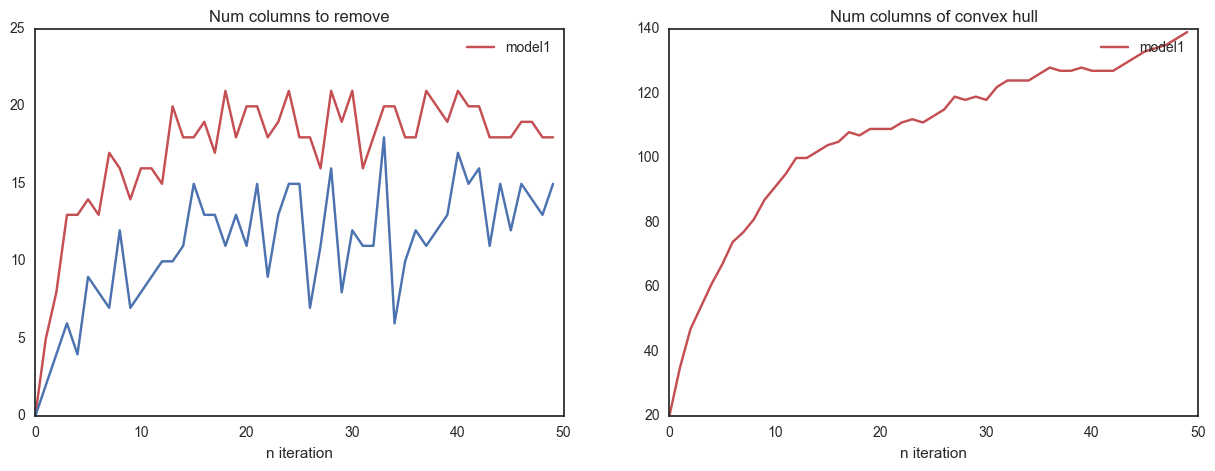

In [241]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
ax1.plot([val['n_topics_to_remove'] for val in iterations_info], color='r', label='model1')
ax1.set_title('Num columns to remove')
ax1.set_xlabel('n iteration')
ax1.legend()

ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r', label='model1')
ax2.set_title('Num columns of convex hull')
ax2.set_xlabel('n iteration')
ax2.legend()

get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
n_topics_removed_from_current_iteration = [[get_topic_iteration_fn(t) for t in it['removed_topics']].count(indx) for indx, it in enumerate(iterations_info)]
ax1.plot(n_topics_removed_from_current_iteration, color='b')


In [244]:
filtered_phi_convex_hull, filtered_iterations_info = filter_convex_hull(phi_convex_hull.copy(), max_iteration=20)

[2017-01-29 20:33:09.297000] take_distances between 139 columns and 139 columns
[2017-01-29 20:33:09.301000] column 0 / 139
[2017-01-29 20:33:11.629000] column 20 / 139
[2017-01-29 20:33:13.710000] column 40 / 139
[2017-01-29 20:33:15.929000] column 60 / 139
[2017-01-29 20:33:18.057000] column 80 / 139
[2017-01-29 20:33:20.149000] column 100 / 139
[2017-01-29 20:33:22.247000] column 120 / 139
[2017-01-29 20:33:24.259000] iteration = 0 / 20
[2017-01-29 20:33:24.259000] get_optimization_result for column 0 / 139
[2017-01-29 20:33:26.885000] get_optimization_result for column 20 / 139
[2017-01-29 20:33:30.921000] get_optimization_result for column 40 / 139
[2017-01-29 20:33:33.839000] get_optimization_result for column 60 / 139
[2017-01-29 20:33:37.092000] get_optimization_result for column 80 / 139
[2017-01-29 20:33:39.808000] get_optimization_result for column 100 / 139
[2017-01-29 20:33:42.224000] get_optimization_result for column 120 / 139
[2017-01-29 20:33:44.958000] 20 topics to re

In [238]:
# to do : save phi_convex on each iteration,
# make plot each iteration , save it
# разобраться почему 
# заодно сразу стабильность мерить
# спроектировать конечный результат на оригинальную 


[0, 2, 4, 6, 4, 9, 8, 7, 12, 7, 8, 9, 10, 10, 11, 15, 13, 13, 11, 13, 11, 15, 9, 13, 15, 15, 7, 11, 16, 8, 12, 11, 11, 18, 6, 10, 12, 11, 12, 13, 17, 15, 16, 11, 15, 12, 15, 14, 13, 15]


In [285]:
filtered_phi_convex_hull_expanded = build_convex_hull(create_model_fn_1, None, init_convex_hull=filtered_phi_convex_hull, start_iteration = 51, max_iteration=50)

[2017-01-29 21:51:36.273000] iteration = 51 / 101
[2017-01-29 21:51:36.273000] creating model
[2017-01-29 21:51:36.399000] adding scores
[2017-01-29 21:51:36.402000] fitting
[2017-01-29 21:51:59.367000] outputting
name = model_20_m1_iter_51, n_topics = 20, n_doc_passes = 5, seed_value = 151, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-01-29 21:52:05.320000] take_distances between 85 columns and 85 columns
[2017-01-29 21:52:05.321000] column 0 / 85
[2017-01-29 21:52:06.962000] column 20 / 85
[2017-01-29 21:52:08.559000] column 40 / 85
[2017-01-29 21:52:10.438000] column 60 / 85
[2017-01-29 21:52:12.224000] column 80 / 85
[2017-01-29 21:52:12.570000] get_optimization_result for column 0 / 85
[2017-01-29 21:52:15.722000] get_optimization_result for column 20 / 85
[2017-01-29 21:52:19.505000] get_optimization_result for column 40 / 85
[2017-01-29 21:52:23.214000] get_optimization_result for column 60 / 85
[2017-01-29 21:52:27.101000] get_optimization_result for column 8

In [265]:
len(filtered_phi_convex_hull)

2216